### 画像をn枚のパッチに分割しノード特徴を対応する画像パッチとする。画像はカラー画像とする。エッジは最近傍ノードにエッジを張る
一応エッジにはパッチ間のコサイン類似度を代入する。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random
import cv2
from tqdm import tqdm
import dgl
import networkx as nx

In [4]:
from torchvision.datasets import STL10
from torchvision import transforms

target_size=(224,224)
transform=transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor()
])

STL10_train = STL10("STL10", split='train', download=True, transform=transform)
 
STL10_test = STL10("STL10", split='test', download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
#パッチサイズ
num_patch=8
#パッチサイズに対応したグラフを作成


224
28


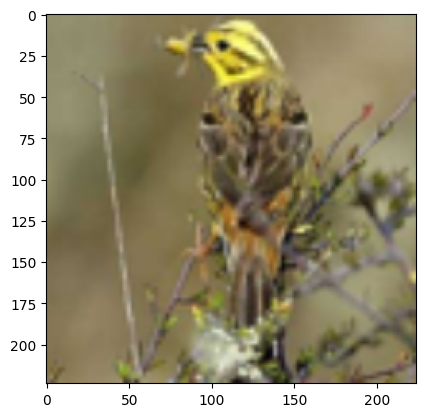

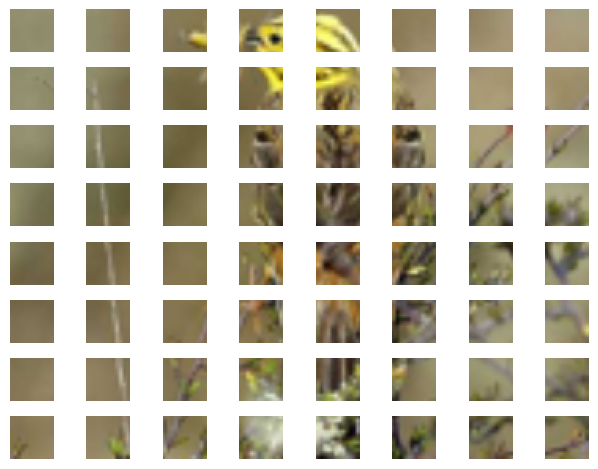

patch num: 8  patch pic size: 28  class: 1


In [9]:
#画像一枚読み込み
image,label=STL10_train[0]
#HWCに入れ替え
image=image.permute(1,2,0)
#表示
plt.imshow(image)
#パッチに分割
#画像をn分割。
num_patch=8
size=image.shape[0]
print(size)
patch_width=int(size/num_patch)
print(patch_width)
data=[]

for i in range(0,size,patch_width):
    #print(i)
    for j in range(0,size,patch_width):
        #print(j)
        data.append(image[i: i + patch_width,j: j + patch_width, :])

#分割した各パッチを正方形に表示
# 1枚の図を作成
fig = plt.figure()

# 画像を追加
for i in range(num_patch**2):
    ax = fig.add_subplot(num_patch, num_patch, i+1)
    ax.imshow(data[i])
    ax.axis('off')

# 画像を表示
plt.tight_layout()
plt.show()
print(f'patch num: {num_patch}  patch pic size: {patch_width}  class: {label}')